# 4. Convolutional neural networks (CNN)

With ANNs, our first step in the MNIST analysis was to flatten the image matrix into a vector. This approach is not translation invariant: 
* a completely different set of nodes gets activated when the image is shifted.
* ignores the dependency between nearby pixels.
* requires a large number of parameters/weights aseach node in the first hidden layer is connected to all nodes in the input layer

Convolutional layers allow to handle multidimensional data, without flattening!

2d convolutional layers use 2 dimensional input (for example images) to construct 2 dimensional feature maps:
* The weights in a 2d convolutional layer are structured in a small image, called the kernel or the filter:
<img src="./imgs/cnn_1.png" alt="cnn_1" style="width: 300px;"/>

* We slide the kernel over the input image, multiply the selected part of the image and the kernel elementwise and sum:
<img src="./imgs/cnn_2.png" alt="cnn_2" style="width: 300px;"/>

In [3]:
# import libs
import os
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from keras import backend as K

seed = 123

def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
reset_random_seeds(seed)

Using TensorFlow backend.


In [4]:
# load mnist data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
# we don't flatten input data this time
x_train = x_train/255
x_test = x_test/255

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
# expand dimension to fourth axis
x_train = tf.expand_dims(x_train, axis = -1, name=None); x_train.shape # -1 to add dimension 'on the right side'
x_test = tf.expand_dims(x_test, axis = -1, name=None); x_test.shape

TensorShape([10000, 28, 28, 1])

In [8]:
print(f'dim x_train:{x_train.shape}, dim x_test:{x_test.shape}')

dim x_train:(60000, 28, 28, 1), dim x_test:(10000, 28, 28, 1)


In [9]:
# the output labels are one-hot encoded
output_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
output_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

### 4.1 Fitting a CNN

In order to fit our CNN we need to add a 2D convolutional layer:

```python
model.add(tf.keras.layers.Conv2D(filters = 8, 
                                 kernel_size = 3,
                                 strides = c(1, 1),
                                 input_shape = (28, 28, 1)))
```
* **filters = 8**: We construct 8 feature maps associated to different kernels/filters.
* **kernel_size = c(3, 3)**: The filter/kernel has a size of 3x3.
* **strides = c(1, 1)**: We move the kernel in steps of 1 pixel in both the horizontal and vertical direction. This is a common choice.
* **input_shape = (28, 28, 1)**: If this is the first layer of the model, we also have to specify the dimensions of the input data. The input consists of 1 image of size 28x28.

A convolution layer is typically followed by a pooling step, which reduces the size of feature maps. Pooling layers divide the image in blocks of equal size
and then aggregate the data per block. Two common operations are:
* average pooling
* max pooling

<img src="./imgs/cnn_3.png" alt="cnn_3" style="width: 300px;"/>

In this case we picked _max pooling_:
```python
model.add(tf.keras.layers.MaxPooling2D(pool_size = 2,
                                      strides = 2))
```
* Pool blocks of 2x2
* Move in steps of size 2 in both the horizontal and vertical direction.

When all features are extracted, the data is flattened.This data can be seen as engineered features, automatically created by the CNN architecture. In a next step, a feed-forward ANN is used to analyze these local features:

<img src="./imgs/cnn_4.png" alt="cnn_4" style="width: 750px;"/>

In [10]:
reset_random_seeds(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.keras.backend.set_session(session_conf)

# fitting convolutional neural netword
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters = 8, 
                                 kernel_size = 3, 
                                 input_shape = (28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size = 2,
                                      strides = 2))

When all features are extracted, the data is flattened. This data can be seen as engineered features, automatically created by the CNN architecture. In a next step, a feed-forward ANN is used to analyze these local features.

In [11]:
model.add(tf.keras.layers.Flatten()) # flattening the data
model.add(tf.keras.layers.Dense(units = 10, activation = 'softmax')) # passing the flattened data to a dense layer
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'RMSprop',
              metrics = ['accuracy'])

tf.compat.v1.keras.backend.clear_session()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(x = x_train,
          y = output_train,
          epochs = 10,
          batch_size = 128,
          validation_split = 0.2,
          verbose = 0)

In [14]:
# evaluate performance
test_loss, test_accuracy = model.evaluate(x_test, output_test, verbose = 0)
print(f'loss:{test_loss}, accuracy:{test_accuracy}')

loss:0.11180946557745337, accuracy:0.967199981212616


In [15]:
# test reproducibility
# 10 epochs - loss:0.11180946557745337, accuracy:0.967199981212616

In [16]:
# prediction using test set
prediction = model.predict(x_test)

In [17]:
# prediction vs actual
predicted_category = np.argmax(prediction, axis = 1)
actual_category = np.argmax(output_test, axis = 1)

In [54]:
# mis-predicted values
mask = np.equal(predicted_category,actual_category)
index_misclas = np.where(~mask)

The number of mis-predicted values

In [19]:
(~mask).sum()

328

(~mask).sum()/mask

Almost 97% of the test images are now correctly classified:

In [31]:
1 - (~mask).sum()/mask.sum()

0.9660876757650951

In [20]:
# test reproducibility
# 328

In [32]:
# bulding df predicted/actual categories
df = pd.DataFrame({'pred_cat':predicted_category,
                   'actual_cat':actual_category}); df.head()

,pred_cat,actual_cat
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


In [33]:
def plot_img_3d_tensor(vector_picture, which, actual_v, predited_v):
    pixels = np.array(vector_picture)[which][:][:][:]
    plt.imshow(pixels, cmap='gray')
    plt.title(f'actual:{actual_category[which]}, predicted:{predicted_category[which]}')
    plt.show()

Let's have a look at the misclassified images:

In [62]:
# vector containing the index of the misclassified images
index_misclas[0]

(array([   8,   18,   92,  149,  247,  259,  320,  321,  340,  352,  381,
         445,  448,  479,  507,  551,  582,  583,  613,  659,  684,  691,
         717,  720,  740,  839,  844,  882,  947,  950,  956,  965,  975,
        1003, 1012, 1014, 1032, 1039, 1045, 1107, 1112, 1181, 1182, 1191,
        1192, 1198, 1206, 1226, 1232, 1247, 1260, 1283, 1299, 1319, 1326,
        1339, 1393, 1463, 1494, 1500, 1522, 1527, 1530, 1549, 1553, 1569,
        1581, 1587, 1609, 1640, 1678, 1681, 1709, 1717, 1718, 1754, 1772,
        1790, 1828, 1868, 1878, 1901, 1952, 2016, 2035, 2040, 2043, 2044,
        2053, 2070, 2098, 2109, 2118, 2129, 2130, 2135, 2174, 2182, 2186,
        2189, 2224, 2266, 2272, 2293, 2299, 2305, 2325, 2369, 2387, 2406,
        2422, 2433, 2454, 2488, 2514, 2526, 2532, 2607, 2648, 2654, 2760,
        2771, 2896, 2906, 2925, 2939, 2953, 2970, 2995, 3005, 3060, 3073,
        3100, 3117, 3206, 3240, 3289, 3329, 3369, 3377, 3422, 3448, 3503,
        3520, 3549, 3550, 3567, 3574, 

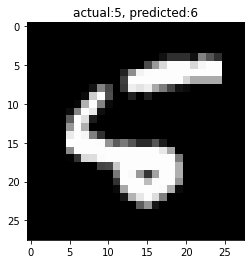

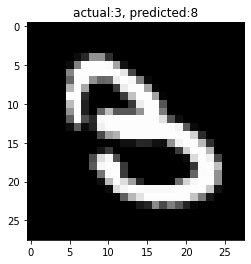

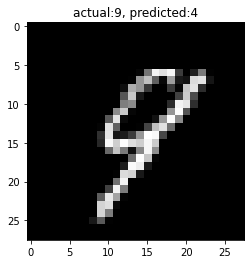

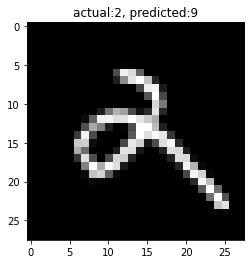

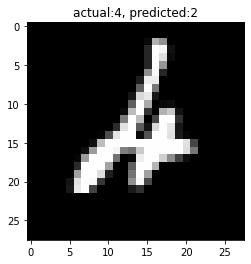

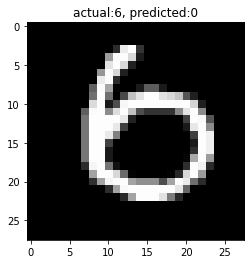

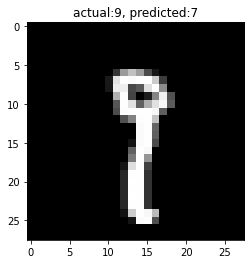

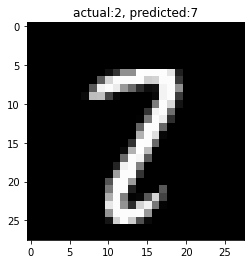

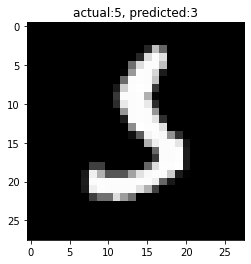

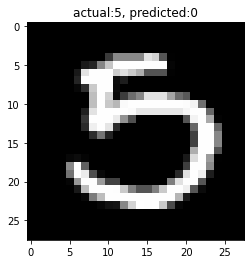

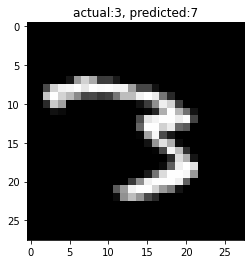

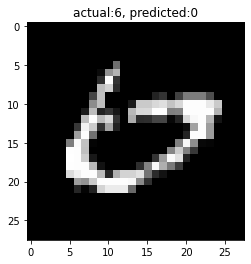

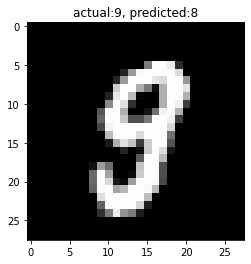

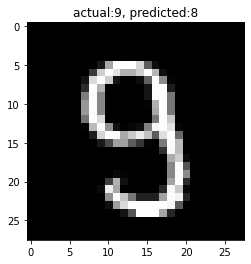

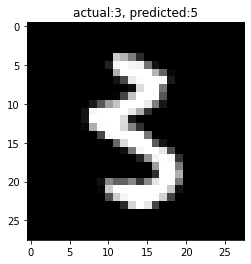

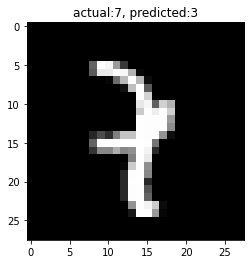

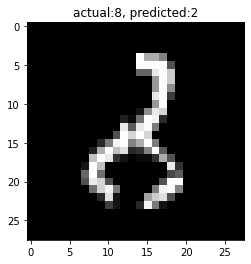

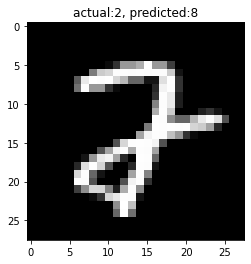

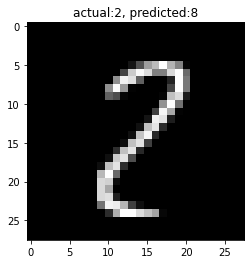

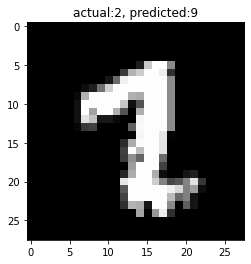

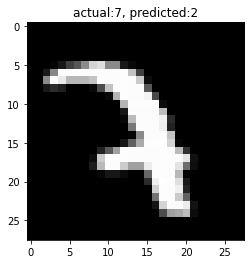

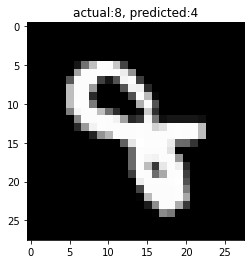

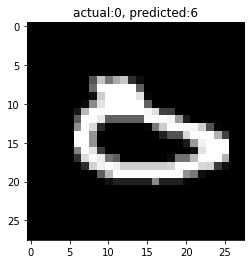

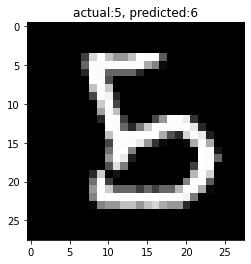

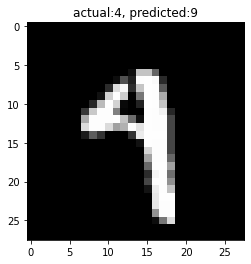

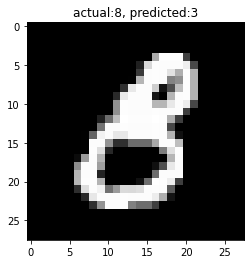

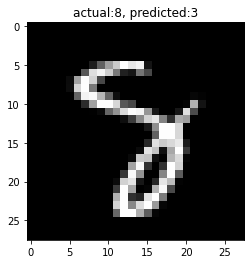

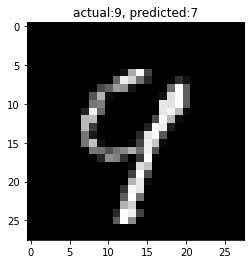

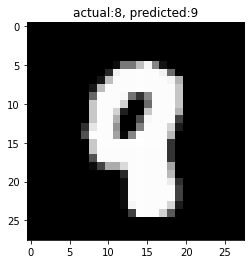

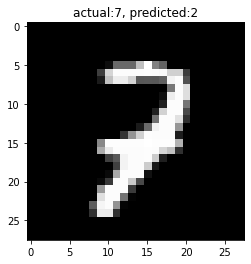

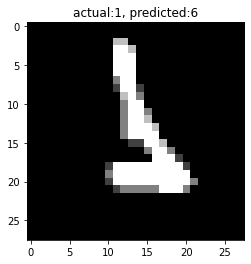

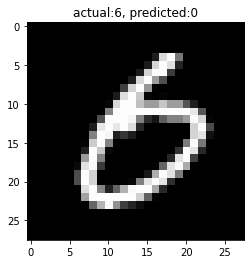

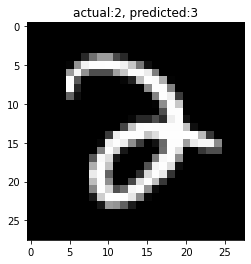

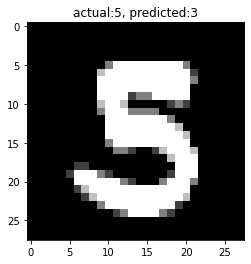

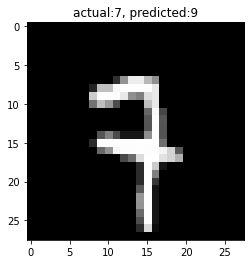

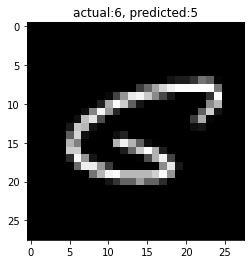

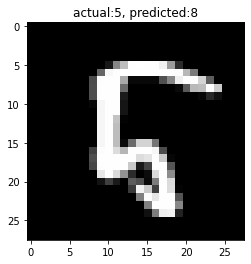

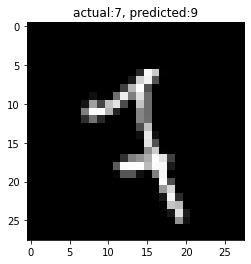

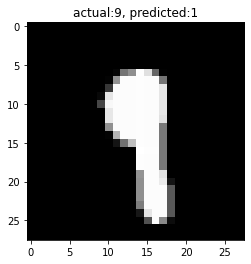

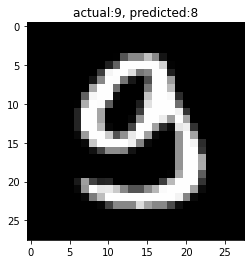

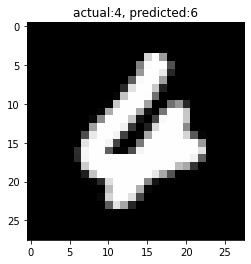

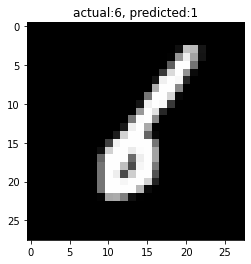

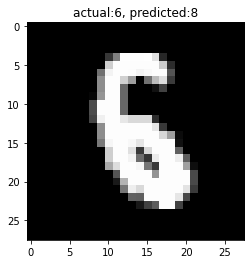

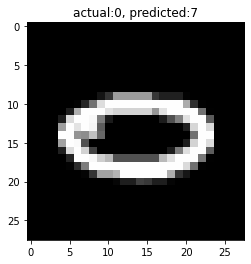

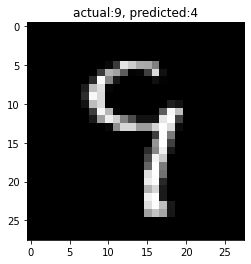

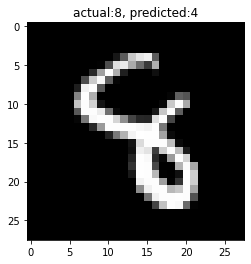

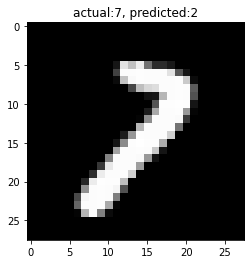

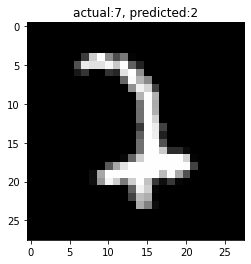

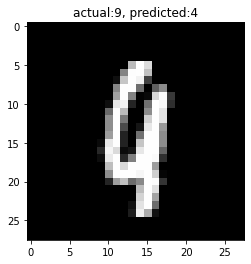

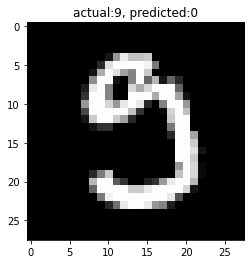

In [65]:
# let's plot the first 50 misclassified pictures
for i in index_misclas[0][:50]:
    plot_img_3d_tensor(x_test, i , df['actual_cat'], df['pred_cat'])

The 8 3x3 filters can be extracted from the _tensorflow.python.keras.layers.convolutional.Conv2D_ layer:

In [23]:
# diplay all the layers in the model
model.layers

Having a look at the structure of the _keras.layers.convolutional.Conv2D_:
* the first two dimensions represent a (3x3) matrix - the dimension coincides with the filter/kernel size specified in the model
* 8 is the number of feature maps and 1 represents the channel

In [76]:
# retrieve weights from the second hidden layer (convolutional layer)
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, filters.shape)

conv2d (3, 3, 1, 8)


In [77]:
#normalize filter values between 0 and 1 for visualization purposes
f_min, f_max = weights.min(), weights.max()
filters = (weights - f_min) / (f_max - f_min)  
print(filters.shape[3])
filter_cnt=1

8


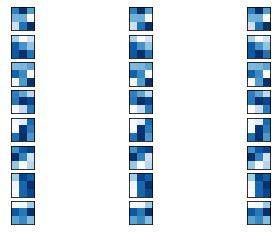

<Figure size 1080x1080 with 0 Axes>

In [97]:
#plotting all the filters
filter_cnt = 1
for i in range(filters.shape[3]):
    
    # get the filters
    filt=filters[:,:,:,i]
    
    # plotting each of the channel, color image RGB channels
    for j in range(filters.shape[0]):
        ax = plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(filt[:,:,:], cmap = 'Blues', interpolation='none')
        filter_cnt+=1
        
plt.figure(figsize=(15, 15))
plt.show()

It is worth noting that each matrix element in the convolution filter is the weights that are being trained. These weights will impact the extracted convolved features.

In [99]:
filters[:,:,:,0] # gradient (top left) matches the values

array([[[0.42008075],
        [0.59515166],
        [0.3518199 ]],

       [[0.29819727],
        [0.3070597 ],
        [0.02418828]],

       [[0.14303386],
        [0.45222193],
        [0.591597  ]]], dtype=float32)